In [162]:
import requests, bs4
import re
import pandas as pd
import time 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### データフレーム作成

In [2]:
cols = ["index","top","left","pitcher","batter","batter_rl","type","speed","result"]
ball_distribution = pd.DataFrame(index=[], columns=cols)

#### スクレイピング

In [3]:
# index : 1回裏：0120100,0120200,...2回裏：0220100,0220200,...
for inning in range(1,11): #1-10回
    print(inning)
    for b_count in range(100,10000,100): #打席
        url= 'https://baseball.yahoo.co.jp/npb/game/2020090503/score?index=0{}20{}'.format(inning,b_count)
        #print(url)
        index = re.search(r'index=\d+', url)
        res = requests.get(url)

        try:
            res.raise_for_status() 
        except requests.exceptions.RequestException:
            print('Not Found Error in {}'.format(index.group())) #Not Foundエラーが出たらその回は終わったとみなす
            break


        soup = bs4.BeautifulSoup(res.text, "html.parser")
        elems = soup.select('.bb-icon__ballCircle')
        elems1 = soup.select('#gm_rslt .bb-splitsTable__data a') #投手、打者
        elems2 = soup.select('.bb-splitsTable__data--ballType') #球種
        elems3 = soup.select('.bb-splitsTable__data--speed') #球速
        elems4 = soup.select('.bb-splitsTable__data--result') #結果
        elems5 = soup.select('#gm_rslt .bb-splitsTable__data') #打者左右
        #print(elems)
        for elem,elem2,elem3,elem4 in zip(elems,elems2,elems3,elems4):
            s = str(elem)
            ball_type = elem2.string
            ball_speed = elem3.string
            top = re.search(r'top:\d+px', s)
            left = re.search(r'left:\d+px', s)
            batter = elems1[0].string
            pitcher = elems1[1].string
            result = elem4.text
            rl = elems5[1].string
            #print(s1)  #投手、打者
            if top != None and left != None:    
                #print(s1)
                #print([int(index.group()[6:]),int(top.group()[4:][:-2]),int(left.group()[5:][:-2]),pitcher,batter,rl,ball_type,ball_speed,result])
                ball_distribution.loc[len(ball_distribution)] = [int(index.group()[6:]),int(top.group()[4:][:-2]),int(left.group()[5:][:-2]),pitcher,batter,rl,ball_type,ball_speed[:-4],result]
        time.sleep(1)

1
[120100, 83, 66, '大貫 晋一', 'ピレラ', '右', 'スプリット', '136km/h', '\n                    見逃し\n                    \n                    \n                  ']
[120100, 40, 68, '大貫 晋一', 'ピレラ', '右', 'ストレート', '140km/h', '\n                    右飛\n                    \n                    \n                  ']
[120200, 160, 60, '大貫 晋一', '菊池 涼介', '右', 'ツーシーム', '143km/h', '\n                    ボール\n                    \n                    \n                  ']
[120200, 83, 92, '大貫 晋一', '菊池 涼介', '右', 'ツーシーム', '142km/h', '\n                    ファウル\n                    \n                    \n                  ']
[120200, 120, 59, '大貫 晋一', '菊池 涼介', '右', 'ツーシーム', '143km/h', '\n                    三ゴロ\n                    \n                    [バウンド高い]\n                  ']
[120300, 82, 100, '大貫 晋一', '堂林 翔太', '右', 'ツーシーム', '145km/h', '\n                    一ゴロ\n                    \n                    [スライディングキャッチ（一）]\n                  ']
Not Found Error in index=0120400
2
[220100, 140, 2, '大貫 晋

[520400, 37, 31, '大貫 晋一', 'ピレラ', '右', 'スライダー', '128km/h', '\n                    見逃し\n                    \n                    \n                  ']
[520400, 159, 29, '大貫 晋一', 'ピレラ', '右', 'スプリット', '137km/h', '\n                    ボール\n                    \n                    \n                  ']
[520400, 87, 61, '大貫 晋一', 'ピレラ', '右', 'ストレート', '141km/h', '\n                    中飛\n                    \n                    \n                  ']
Not Found Error in index=0520500
6
[620100, 22, 126, '大貫 晋一', '菊池 涼介', '右', 'ツーシーム', '140km/h', '\n                    ボール\n                    \n                    \n                  ']
[620100, 56, 68, '大貫 晋一', '菊池 涼介', '右', 'ツーシーム', '141km/h', '\n                    中飛\n                    \n                    \n                  ']
[620200, 60, 32, '大貫 晋一', '堂林 翔太', '右', 'ストレート', '145km/h', '\n                    見逃し\n                    \n                    \n                  ']
[620200, 135, 29, '大貫 晋一', '堂林 翔太', '右', 'スプリット', '13

[920500, 59, 122, '大貫 晋一', '田中 広輔', '左', 'スライダー', '130km/h', '\n                    ボール\n                    \n                    \n                  ']
[920500, 100, 102, '大貫 晋一', '田中 広輔', '左', 'ツーシーム', '141km/h', '\n                    空振り\n                    \n                    \n                  ']
[920500, 174, 104, '大貫 晋一', '田中 広輔', '左', 'スプリット', '135km/h', '\n                    空振り\n                    \n                    [ワンバウンド]\n                  ']
[920500, 129, 76, '大貫 晋一', '田中 広輔', '左', 'スプリット', '137km/h', '\n                    中飛\n                    \n                    \n                  ']
Not Found Error in index=0920600
10
Not Found Error in index=01020100


In [153]:
ball_distribution

,index,top,left,pitcher,batter,batter_rl,type,speed,result
0,120100,83,66,大貫 晋一,ピレラ,右,スプリット,136,見逃し
1,120100,40,68,大貫 晋一,ピレラ,右,ストレート,140,右飛
2,120200,160,60,大貫 晋一,菊池 涼介,右,ツーシーム,143,ボール
3,120200,83,92,大貫 晋一,菊池 涼介,右,ツーシーム,142,ファウル
4,120200,120,59,大貫 晋一,菊池 涼介,右,ツーシーム,143,三ゴロ
...,...,...,...,...,...,...,...,...,...
106,920400,91,103,大貫 晋一,メヒア,右,ストレート,140,左安
107,920500,59,122,大貫 晋一,田中 広輔,左,スライダー,130,ボール
108,920500,100,102,大貫 晋一,田中 広輔,左,ツーシーム,141,空振り
109,920500,174,104,大貫 晋一,田中 広輔,左,スプリット,135,空振り


In [152]:
# 型変換
ball_distribution["top"] = ball_distribution["top"].astype(int)
ball_distribution["left"] = ball_distribution["left"].astype(int)
ball_distribution["speed"] = ball_distribution["speed"].astype(int)
# 空白、改行、[]削除
ball_distribution["result"] = ball_distribution["result"].str.replace(" ","").str.replace("\n","").str.replace(r"\[.+\]","")

In [146]:
# 球種
ball_distribution["type"].value_counts()

スプリット     31
ストレート     22
ツーシーム     19
スライダー     18
カットボール    13
カーブ        8
Name: type, dtype: int64

In [154]:
# 結果
ball_distribution["result"].value_counts()

ボール     30
見逃し     21
ファウル    17
空振り      8
空三振      4
遊ゴロ      4
右飛       4
中飛       4
三ゴロ      3
二ゴロ      3
左２       2
左安       2
中安       2
右安       1
三飛       1
右２       1
一ゴロ      1
投ゴロ      1
左邪飛      1
捕犠打      1
Name: result, dtype: int64

#### 配球を散布図にする
- htmlからストライクゾーンを推定して描画

C:\Users\remi\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


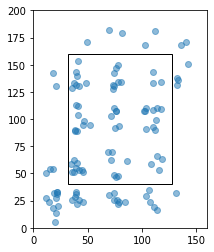

In [155]:
# 配球
fig = plt.figure()
ax = fig.add_subplot(111)
# ストライクゾーン
rect = plt.Rectangle((32,40),96,120,fc="#770000",fill=False)
ax.add_patch(rect)

# ピクセル値の調整
x = ball_distribution["left"]+10
y = 200-ball_distribution["top"]-10
ax.scatter(x, y,alpha=0.5)
plt.xlim(0, 160)
plt.ylim(0, 200)
# アスペクト比を調節
plt.axes().set_aspect('equal')
plt.show()

- ライン上に球が来ていないのはサイトの都合と思われる

#### ストライクゾーンの確認
- 念のためボール判定のボールを確認

C:\Users\remi\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\remi\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


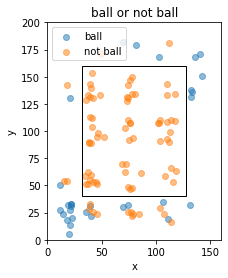

In [156]:
ballzone = ball_distribution[ball_distribution["result"]=="ボール"]
strike_out = ball_distribution[ball_distribution["result"]!="ボール"]

x1 = ballzone["left"]+10
y1 = 200-ballzone["top"]-10

x2 = strike_out["left"]+10
y2 = 200-strike_out["top"]-10

fig = plt.figure()
ax = fig.add_subplot(111)
rect = plt.Rectangle((32,40),96,120,fill=False) #ストライクゾーン
ax.add_patch(rect)

ax.scatter(x1, y1,alpha=0.5,label="ball")
ax.scatter(x2, y2,alpha=0.5,label="not ball")

plt.xlim(0, 160)
plt.ylim(0, 200)
plt.axes().set_aspect('equal')

ax.set_title('ball or not ball')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend(loc='best')
fig.show()


- ボール判定された球がストライクゾーンの枠の外にあることが確認できた

#### 左右打者の比較

C:\Users\remi\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


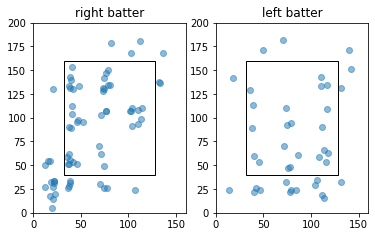

In [157]:
rightbatter = ball_distribution[ball_distribution["batter_rl"]=="右"]
leftbatter = ball_distribution[ball_distribution["batter_rl"]=="左"]


x1 = rightbatter["left"]+10
y1 = 200-rightbatter["top"]-10

x2 = leftbatter["left"]+10
y2 = 200-leftbatter["top"]-10

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
rect1 = plt.Rectangle((32,40),96,120,fill=False)
rect2 = plt.Rectangle((32,40),96,120,fill=False)
ax1.add_patch(rect1)
ax2.add_patch(rect2)

ax1.scatter(x1, y1,alpha=0.5)
ax2.scatter(x2, y2,alpha=0.5)

ax1.set_title('right batter')
ax2.set_title('left batter')

ax1.set_xlim(0, 160)
ax1.set_ylim(0, 200)
ax2.set_xlim(0, 160)
ax2.set_ylim(0, 200)

ax1.set_aspect('equal')
ax2.set_aspect('equal')
fig.show()

- 右打者に対してはインサイド高め、アウトローに多く投げられている
- 左打者に対してはそもそもサンプルが少ないのもあるが、散らばっている印象

C:\Users\remi\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


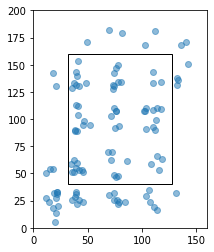

In [159]:
# 配球
fig = plt.figure()
ax = fig.add_subplot(111)
# ストライクゾーン
rect = plt.Rectangle((32,40),96,120,fc="#770000",fill=False)
ax.add_patch(rect)

# ピクセル値の調整
x = ball_distribution["left"]+10
y = 200-ball_distribution["top"]-10
ax.scatter(x, y,alpha=0.5)
plt.xlim(0, 160)
plt.ylim(0, 200)
# アスペクト比を調節
plt.axes().set_aspect('equal')
plt.show()

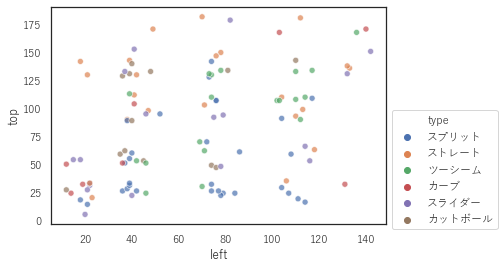

In [211]:
x1 = ball_distribution["left"]+10
y1 = 200-ball_distribution["top"]-10
#sns.set_style('white')
sns.set(style='white',font='Yu Gothic')
sns.scatterplot(x=x1,y=y1,hue="type",data=ball_distribution,alpha=0.7)
ax = plt.gca()
ax.legend(loc="upper right",bbox_to_anchor=(0.35,0.5,1.0,0.05))